## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [18]:
import glob

import numpy as np
import scipy as sp
import scipy.io
from scipy import signal
import matplotlib.pyplot as plt
plt.ioff()

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def apply_bp_filter(sig, fs=125, low_cutoff=40, high_cutoff=240):
    """
    Bandpass filter function

    Performs a bandpass filter using the provided cutoff thresholds

    Returns:
        A filtered signal
    """
    b, a = signal.butter(3, [low_cutoff/60, high_cutoff/60], btype='bandpass', fs=fs)
    filt_sig = signal.filtfilt(b, a, sig)
    return filt_sig

def get_specgram_results(signal, fs=125, low_cutoff=40, high_cutoff=240):
    """
    Specgram calculation function

    Uses matplotlibs specgram function to calculate a FT specgram.
    Filters the results to the provided cutoff thresholds.

    Returns:
        Filtered specgram frequencies and frequency magnitudes
    """
    signal_spec, signal_freqs, _, _ = plt.specgram(signal, NFFT=fs*12, Fs=fs, noverlap=fs*10)
    freq_filter = (signal_freqs >= low_cutoff/60) & (signal_freqs < high_cutoff/60)
    filtered_signal_freqs = signal_freqs[freq_filter]
    filtered_signal_spec = signal_spec[freq_filter]
    
    return filtered_signal_freqs, filtered_signal_spec

def get_hr_and_conf(ppg, accx, accy, accz, fs=125):
    """
    Heartrate estimator and confidence function

    Calculates an initial estimate of heart rate based on the PPG dominant frequency.
    Performs refinement to PPG dominant frequency via comparison to accelerometer dominant frequencies.
    Calculates a confidence score as the intensity of the PPG dominant frequency vs. total signal intensity.

    Returns:
        Initial heart rate estimates and confidence scores
    """
    # get specgram results for all signals
    filtered_ppg_freqs, filtered_ppg_spec = get_specgram_results(ppg)
    filtered_accx_freqs, filtered_accx_spec = get_specgram_results(accx)
    filtered_accy_freqs, filtered_accy_spec = get_specgram_results(accy)
    filtered_accz_freqs, filtered_accz_spec = get_specgram_results(accz)

    hrs = []
    confs = []
    for i in range(filtered_ppg_spec.shape[1]):
        # for each windowed chunk of frequency magnitudes
        ppg_chunk = filtered_ppg_spec[:, i]
        accx_chunk = filtered_accx_spec[:, i]
        accy_chunk = filtered_accy_spec[:, i]
        accz_chunk = filtered_accz_spec[:, i]

        # we select an initial dominant frequency for each modality
        dom_ppg = filtered_ppg_freqs[ppg_chunk.argmax()]
        dom_accx = filtered_accx_freqs[accx_chunk.argmax()]
        dom_accy = filtered_accy_freqs[accy_chunk.argmax()]
        dom_accz = filtered_accz_freqs[accz_chunk.argmax()]

        # compare initial dominant PPG frequency to accelerometer dominant freqs and make adjustments
        while np.isclose(dom_ppg, dom_accx, atol=0.1):
            ppg_chunk[ppg_chunk.argmax()] = 0
            dom_ppg = filtered_ppg_freqs[ppg_chunk.argmax()]

        while np.isclose(dom_ppg, dom_accy, atol=0.1):
            ppg_chunk[ppg_chunk.argmax()] = 0
            dom_ppg = filtered_ppg_freqs[ppg_chunk.argmax()]

        while np.isclose(dom_ppg, dom_accz, atol=0.1):
            ppg_chunk[ppg_chunk.argmax()] = 0
            dom_ppg = filtered_ppg_freqs[ppg_chunk.argmax()]

        # best estimate of heart rate with acc freqs removed
        hrs.append(dom_ppg * 60)

        # calculate a confidence as the proportion of intensity of the dominate PPG freq
        conf = ppg_chunk[ppg_chunk.argmax()] / ppg_chunk.sum()
        confs.append(conf)
        
    return hrs, confs


def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Entry point of algorithm
    
    Loads each data file consisting of PPG and Accelerometer data.
    Performs a band pass filter for all signals.
    Gets initial heart rate estimates and confidence.
    Performs a smoothing of initial heart rate estimates to reduce outliers.
    Calculates absolute errors compared to reference hearrate data

    Returns:
        Errors and confidence score of heart rate estimates
    """
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    ref_data = sp.io.loadmat(ref_fl)['BPM0'].reshape(-1)

    # pass band filter for all signals
    ppg = apply_bp_filter(ppg)
    accx = apply_bp_filter(accx)
    accy = apply_bp_filter(accy)
    accz = apply_bp_filter(accz)

    # get initial hr estimate and confidences
    hrs, confs = get_hr_and_conf(ppg, accx, accy, accz)

    # perform a smoothing of initial hr estimates
    smoothed_hrs = signal.savgol_filter(hrs, 37, 1)
    
    # calculate error to reference data
    errors = np.abs(smoothed_hrs - ref_data.flatten()[-len(smoothed_hrs):])
    confidence = np.array(confs)

    return errors, confidence

Aggregate Error Metric:  6.15075367719


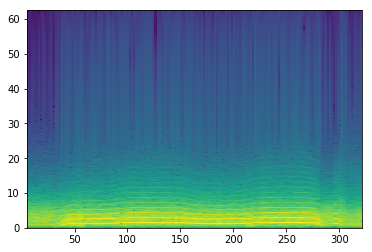

In [19]:
plt.ioff()
error_metric = Evaluate()
print("Aggregate Error Metric: ", error_metric)

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

#### Code Description
The entry point of the code is the RunPulseRateAlgorithm function. The function takes as input individual data_fl, ref_fl filepaths, which contain the raw signal data and reference heart rate data, respectively.
The Evaluate function is used to perform an evaluation of the algorithm over the whole dataset.
#### Data Description
The data used is obtained from The study, "TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise" 
The data used consist of PPG and accelerometer signals sampled at 125 Hz.
The data also consist of calculated ground-truth heart rates in 8s time windows with 6s of overlap.
#### Algorithhm Description
The pulse rate (heart rate) estimation algorithm consists of the following steps:
1. Band pass filter of the raw PPG signal and each accelerometer signal (axes x, y, and z) to a heart rate frequency range of 40-240 BPM.
2. For each signal, the signals in the time domain are then transformed into the frequency domain via Fourier transform in overlapping windows of 12 seconds with 10 seconds of overlap. The specific values were selected based on visual inspection of specgrams.
3. Filtering of the specgram outputs to the frequency range of 40-240 BPM
4. For all filtered outputs, the dominant frequency in each of the specgram windows was determined.
5. The dominant frequency of the PPG signal was compared for similarity to the dominant frequency of each accelerometer signal.
6. If the dominant frequency of the PPG signal is close (i.e., below a specific threshold) to that of the accelerometer signal, the next most intense PPG frequecny is choosen (i.e., motion compensation).
7. The final PPG frequency choose is multiplied by 60 to convert into a heart rate.
8. A confidence value is calculated for the heart rate estimation by dividing the intensity of the final PPG frequency by the sum total intensity of the specgram window.
9. To adjust for outlier effects, the final heart rate estimation is smoothed using a Savitzky–Golay filter.

#### Algorithm Performance 
The performance of the algorithm is evaluated by comparison to a reference heart rate signal. Specifically, we calculate the individual error as the absolute deviation of the estimated heart rate and the reference heart rate.
The final aggregated error reported is the mean of all individual errors where the estimated heart rate has a confidence score above 90%.

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 